<a href="https://colab.research.google.com/github/seank934/project1/blob/main/project_1_envecon_153.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1 

In [ ]:
!pip install wbdata
import wbdata
import pandas as pd
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import cufflinks as cf
import seaborn as sns
import matplotlib.pyplot as plt
!pip install geopandas
import geopandas

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [ ]:
SOURCE = 40
indicators = wbdata.get_indicator(source = SOURCE)
#indicators

In [ ]:
wbdata.get_dataframe({"SP.POP.5559.MA":"Russia Population", "SP.POP.AG23.MA.IN": "hello"}, country="RUS")

,Russia Population,hello
date,,
2021,NaN,NaN
2020,4602435.0,682333.0
2019,4727216.0,734315.0
2018,4778335.0,785540.0
2017,4777615.0,835162.0
...,...,...
1964,2005496.0,849046.0
1963,1902053.0,1034048.0
1962,1801633.0,1240861.0


## [#A] Population Statistics

In [ ]:
def round_first(age):
  k = age - age % 5
  return np.max([0, k])

def round_last(age):
  return age - age % 5 + 4


def population(year, sex, age_range, place):
  # find population dataframe for age range (currently assuming age_range values are multiple of 5; add interpolation in the future)
  variable_labels = []
  
  sex_postfix = "MA"
  if sex == "Female":
    sex_postfix = "FE"
  first = round_first(age_range[0])
  last = np.min([80, round_last(age_range[1])])
  for i in range(first, last, 5):
    variable_labels.append("SP.POP." + f"{i:02d}" + f"{i+4:02d}" + "." + sex_postfix)
  
  # manually add 80UP 
  if age_range[1] >= 80:
    variable_labels.append("SP.POP.80UP." + sex_postfix)
    
  empty_dict = {}
  for i in variable_labels:
      empty_dict[i] = i
  pop = wbdata.get_dataframe(empty_dict, country=place)
  pop = pop.transpose()
  pop = pop[str(year)].sum()
  return pop

In [ ]:
population(year=1966,sex='Male',age_range=(18,26),place='RUS')

14827326.0

In [ ]:
# assert population(year=2000,sex='Male',age_range=(0,100),place='WLD') > 7e9
# This should be false because the male population should never be exceeding 7 billion in the year 2000 as that is the entire world population.

## [#A] Population DataFrames



In [ ]:
def new_pop(place):
  # find population dataframe for age range (currently assuming age_range values are multiple of 5; add interpolation in the future)
  variable_labels_male = {}
  variable_labels_female = {}
  
  for i in range(0, 80, 5):
    variable_labels_male["SP.POP." + f"{i:02d}" + f"{i+4:02d}" + "." + 'MA'] = (i, i+4)
    variable_labels_female["SP.POP." + f"{i:02d}" + f"{i+4:02d}" + "." + 'FE'] = (i, i+4)
  
  # manually add 80UP 
  variable_labels_male["SP.POP.80UP." + 'MA'] = ('80 and up')
  variable_labels_female["SP.POP.80UP." + 'FE'] = ('80 and up')

  pop_m = wbdata.get_dataframe(variable_labels_male, country=place)
  pop_m = pop_m.transpose()
  pop_m = pop_m.stack().reset_index(-1).iloc[:, ::-1]
  pop_m = pop_m.reset_index()
  pop_m = pop_m.rename(columns={0: 'male', "index": "age group"})

  pop_f = wbdata.get_dataframe(variable_labels_female, country=place)
  pop_f = pop_f.transpose()
  pop_f = pop_f.stack().reset_index(-1).iloc[:, ::-1]
  pop_f = pop_f.reset_index()
  pop_f = pop_f.rename(columns={0: 'female', "index": "age group"})

  pop =  pd.merge(pop_m, pop_f,  how='left', left_on=['age group','date'], right_on = ['age group','date'])

  return pop

In [ ]:
new_pop(place='RUS')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9138: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)



,age group,male,date,female
0,"(0, 4)",4703088.0,2020,4452313.0
1,"(0, 4)",4781058.0,2019,4524512.0
2,"(0, 4)",4838806.0,2018,4576591.0
3,"(0, 4)",4868384.0,2017,4602696.0
4,"(0, 4)",4843381.0,2016,4579788.0
...,...,...,...,...
1032,80 and up,318272.0,1964,923010.0
1033,80 and up,310111.0,1963,884717.0
1034,80 and up,297620.0,1962,841338.0
1035,80 and up,282229.0,1961,793681.0


## [#B] Population Pyramids

In [ ]:
def pop_pyramid(df):
  age_ranges = []
  # creating population pyramid in increments of 5 years
  for i in range(0,100,5):
    age_ranges.append(f"{i:02d}"+f"{i+4:02d}")

  age_ranges.append("80UP")

  layout = go.Layout(barmode='overlay',
                   yaxis=go.layout.YAxis(range=[0, 100], title='Age'),
                   xaxis=go.layout.XAxis(title='Population'))

  # distinguishing between male and female (two sides of the pyramid)
  bins = [go.Bar(x = df['male'],
               y = [int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Men',
               marker=dict(color='purple'),
               hoverinfo='skip'
               ),

        go.Bar(x = -df['female'],
               y=[int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Women',
               marker=dict(color='pink'),
               hoverinfo='skip',
               )
        ]
  py.iplot(dict(data=bins, layout=layout))

In [ ]:
pop_pyramid(new_pop(place='RUS'))

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9138: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)



## [#C] Animated Population Pyramids

In [ ]:
def pop_pyramid_ani(year):
  age_ranges = []
  df = new_pop(place='RUS')
  df = df[df['date'] == str(year)]
  # creating population pyramid in increments of 5 years
  for i in range(0,80,5):
    age_ranges.append(f"{i:02d}"+f"{i+4:02d}")

  age_ranges.append("80UP")

  layout = go.Layout(barmode='overlay',
                   yaxis=go.layout.YAxis(range=[0, 90], title='Age'),
                   xaxis=go.layout.XAxis(title='Population'))

  # distinguishing between male and female (two sides of the pyramid)
  bins = [go.Bar(x = df['male'],
               y = [int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Men',
               marker=dict(color='purple'),
               hoverinfo='skip'
               ),

        go.Bar(x = -df['female'],
               y=[int(s[:2])+1 for s in age_ranges],
               orientation='h',
               name='Women',
               marker=dict(color='pink'),
               hoverinfo='skip',
               )
        ]
  py.iplot(dict(data=bins, layout=layout))

In [ ]:
years = new_pop(place='RUS')['date']
years.sort_values
max = years[0]
min = years.values[-1]

interact(pop_pyramid_ani, year=(int(min), int(max)))

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9138: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)



interactive(children=(IntSlider(value=1990, description='year', max=2020, min=1960), Output()), _dom_classes=(…

<function __main__.pop_pyramid_ani>

TypeError: ignored

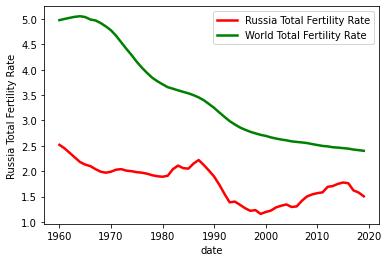

In [ ]:
# fertility rate visualization 
cf.go_offline()
wbdata.get_country('RUS')

variable_labels = {"SP.DYN.TFRT.IN":"Russia Total Fertility Rate"}

RUS_FR = wbdata.get_dataframe(variable_labels, country="RUS")
RUS_FR = RUS_FR.reset_index()
# By Russian fertility from 1960 - 2020
RUS_FR['date'] = RUS_FR['date'].astype(int)
# By World fertility from 1960 - 2020
variable_labels = {"SP.DYN.TFRT.IN":"World Total Fertility Rate"}
WLD_FR = wbdata.get_dataframe(variable_labels, country="WLD")
WLD_FR = WLD_FR.reset_index()
WLD_FR['date'] = WLD_FR['date'].astype(int)

fig, ax = plt.subplots()
sns.lineplot(data=RUS_FR, x="date", y="Russia Total Fertility Rate", 
             label = 'Russia Total Fertility Rate', color='red', linewidth=2.5, dashes=(5, 1), ax = ax)
sns.lineplot(data=WLD_FR, x="date", y="World Total Fertility Rate", 
             label = 'World Total Fertility Rate', color='green', linewidth=2.5, ax = ax)



plt.xticks(np.arange(min(RUS_FR['date']), max(RUS_FR['date'])+1, 10))
ax.set(xlabel='Year', ylabel='Total Fertility Rate (births per woman)');

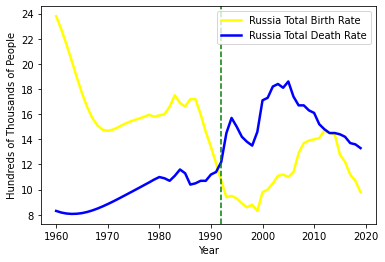

In [ ]:

# birth vs death rate
new_variable_label = {"SP.DYN.CBRT.IN":"Russia Total Birth Rate"}
# birth rate
RUS_BR = wbdata.get_dataframe(new_variable_label, country="RUS")
RUS_BR = RUS_BR.reset_index()

RUS_BR['date'] = RUS_BR['date'].astype(int)

next_variable_label = {"SP.DYN.CDRT.IN":"Russia Total Death Rate"}
# death rate
RUS_DR = wbdata.get_dataframe(next_variable_label, country="RUS")
RUS_DR = RUS_DR.reset_index()

RUS_DR['date'] = RUS_DR['date'].astype(int)

fig, ax = plt.subplots()
sns.lineplot(data=RUS_BR, x="date", y="Russia Total Birth Rate", 
             label = 'Russia Total Birth Rate', color='yellow', linewidth=2.5, dashes=(5, 1), ax = ax)
sns.lineplot(data=RUS_DR, x="date", y="Russia Total Death Rate", 
             label = 'Russia Total Death Rate', color='blue', linewidth=2.5, dashes=(5, 1), ax = ax)

# line indicates intersection point
plt.axvline(x = 1992, color = 'green', linestyle = '--')

plt.xticks(np.arange(min(RUS_BR['date']), max(RUS_BR['date'])+1, 10))
ax.set(xlabel='Year', ylabel='Hundreds of Thousands of People');

## Part C: Population Maps

In [ ]:
path_to_data = geopandas.datasets.get_path("nybb")
gdf = geopandas.read_file(path_to_data)

gdf

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."
